# Python Application Chapter 

## Managing the imports and implementation of the data set

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from tqdm import tnrange,tqdm_notebook
from sklearn import linear_model
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.metrics import mean_squared_error as m
from scipy import stats
import random

df = pd.read_csv("NBA_salaries_and_stats.csv", sep=",")

## Using only variables that are not dependent on each other

In [2]:
df=df[['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']]

## Implementing created methods

In [3]:
from underlying_functions import General as G
from underlying_functions import Regularization as R
from underlying_functions import Combined as C
from underlying_functions import Subset as S

## Subset selection processes
* **best subset**
* **forward stepwise selection**
* **backward stepwise elimination**
* **information criterion selection**

## Working with the subset methods

In [4]:
#creating a training and testing dataframe
df_train= df.sample(frac=0.7,random_state=1)
df_test=df.drop(df_train.index)
#comparing the three methods with the first 14 variables of the dataset
df_train_auswahl=df_train.iloc[:,:14]
df_train_auswahl['salary']=df_train['salary']

## **`best subset`**

In [5]:
#calculating the best subset selection process and saving it as df_bs
df_bs=S.best_subset(df_train_auswahl,output='salary')
#filter df_bs after the subsets with the minimal RSS and displaying the results in the end
df_bs_min_rss=df_bs[df_bs['min_RSS']==df_bs['RSS']][['number_of_variables','RSS','R_squared','variables']].reset_index()
df_bs_min_rss=df_bs_min_rss.drop(['index'], axis=1)
display(df_bs_min_rss)#this diplays the Figure 4.2.2

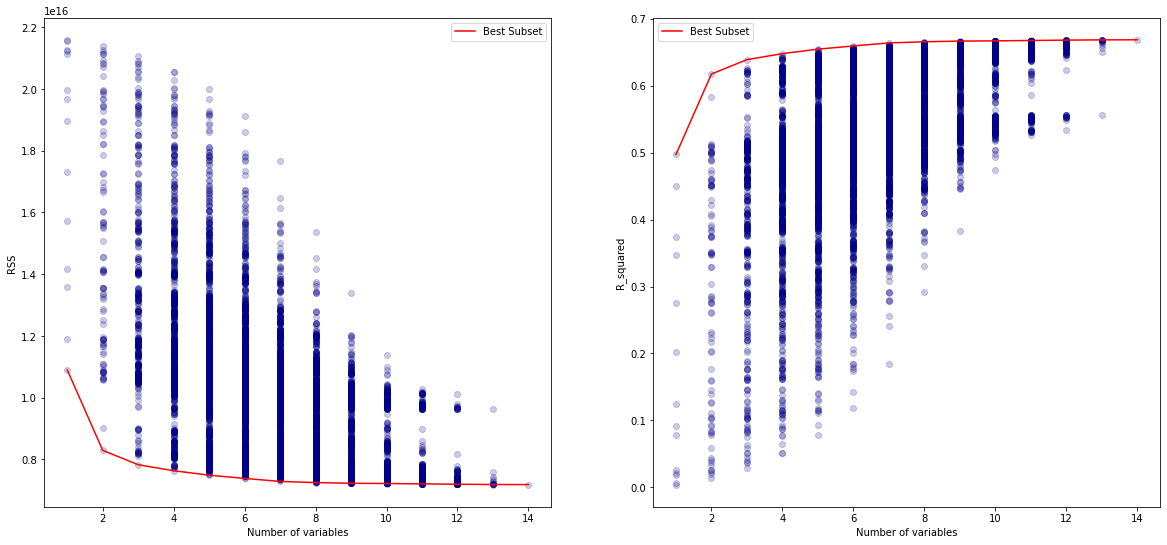

In [ ]:
#the following plots show all subsets in blue and the best subset choice in red 
#with their corresponding RSS/R-squared values
fig=plt.figure(figsize=(20,9))
ax=fig.add_subplot(1,2,1)
ax.scatter(df_bs.number_of_variables,df_bs.RSS,alpha=0.2,color='darkblue')
ax.set_xlabel('Number of variables')
ax.set_ylabel('RSS')
ax.plot(df_bs.number_of_variables,df_bs.min_RSS,color='r',label='Best Subset')
ax.legend()
ax=fig.add_subplot(1,2,2)
ax.scatter(df_bs.number_of_variables,df_bs.R_squared,alpha=0.2,color='darkblue')
ax.set_xlabel('Number of variables')
ax.set_ylabel('R_squared')
ax.plot(df_bs.number_of_variables,df_bs.max_R_squared,color='r',label='Best Subset')
ax.legend()
plt.show()

In [ ]:
#showing the optimal subset for each information criterion
df1,df2,df3=S.ic(df_bs_min_rss['variables'],df_train_auswahl,df_test,output='salary')
print(display(df2))

,aic,bic,r_squaredadj,variables,mse,nf
,,,,,,
MIN AIC,6930.911736,6957.417383,0.819272,"[+/-, 3P%, AGE, DD2, FG%, FP, GP, PTS]",3.457007e+13,8
MIN BIC,6930.911736,6957.417383,0.819272,"[+/-, 3P%, AGE, DD2, FG%, FP, GP, PTS]",3.457007e+13,8
MAX ADJ. R-sq.,6932.041588,6965.173647,0.819963,"[+/-, 3P%, AGE, DD2, FG%, FP, FT%, GP, PF, PTS]",3.356248e+13,10
MIN MSE TEST,6935.228785,6974.987257,0.818804,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, FP, FT%, G...",3.286815e+13,12


None


## **`forward stepwise selection`**

In [ ]:
df_fss=S.forward_stepwise(df_train_auswahl,output='salary')
display(df_fss)#this diplays the Figure 4.3.2

,variables,RSS,R_squared,number of variables
1,[FP],1.089929e+16,0.497275,1
2,"[FP, AGE]",8.291898e+15,0.617540,2
3,"[FP, AGE, FG%]",7.826176e+15,0.639021,3
4,"[FP, AGE, FG%, 3P%]",7.631272e+15,0.648011,4
5,"[FP, AGE, FG%, 3P%, +/-]",7.487532e+15,0.654641,5
6,"[FP, AGE, FG%, 3P%, +/-, PTS]",7.383353e+15,0.659446,6
7,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2]",7.284740e+15,0.663995,7
8,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP]",7.247789e+15,0.665699,8
9,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP, PF]",7.225291e+15,0.666737,9
10,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP, PF, FT%]",7.217586e+15,0.667092,10


In [ ]:
#calculating and showing the optimal subset for each information criterion
df1,df2,df3=S.ic(df_fss['variables'],df_train,df_test,output='salary')
display(df2)

,aic,bic,r_squaredadj,variables,mse,nf
,,,,,,
MIN AIC,6930.911736,6957.417383,0.819272,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP]",3.457007e+13,8
MIN BIC,6930.911736,6957.417383,0.819272,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP]",3.457007e+13,8
MAX ADJ. R-sq.,6932.041588,6965.173647,0.819963,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP, PF, FT%]",3.356248e+13,10
MIN MSE TEST,6935.228785,6974.987257,0.818804,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP, PF, FT%...",3.286815e+13,12


## **`backward stepwise elimination`**

In [ ]:
df_be=S.backwards_elimination(df_train_auswahl,output='salary')
display(df_be)#this display is shown as Fig. 4.4.2

,Variables,RSS,R_squared,Eliminated,Number_of_variables
1,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, FT%, GP, M...",7.185583e+15,0.668568,FP,13
2,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, MIN, P...",7.194414e+15,0.668161,FT%,12
3,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PF, PT...",7.207181e+15,0.667572,MIN,11
4,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PTS, REB]",7.222090e+15,0.666884,PF,10
5,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PTS]",7.253175e+15,0.665450,REB,9
6,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, PTS]",7.280694e+15,0.664181,GP,8
7,"[+/-, 3P%, AGE, AST, DD2, FG%, PTS]",7.427065e+15,0.657430,BLK,7
8,"[+/-, 3P%, AGE, DD2, FG%, PTS]",7.550906e+15,0.651718,AST,6
9,"[3P%, AGE, DD2, FG%, PTS]",7.771981e+15,0.641521,+/-,5
10,"[3P%, AGE, DD2, PTS]",8.141361e+15,0.624483,FG%,4


In [ ]:
#calculating and showing the optimal subset for each information criterion
df1,df2,df3=S.ic(df_be['Variables'],df_train,df_test,output='salary')
display(df2)

,aic,bic,r_squaredadj,variables,mse,nf
,,,,,,
MIN AIC,6932.757739,6962.576593,0.818478,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PTS]",3.348882e+13,9
MIN BIC,6939.480169,6959.359404,0.809681,"[+/-, 3P%, AGE, DD2, FG%, PTS]",3.630277e+13,6
MAX ADJ. R-sq.,6932.757739,6962.576593,0.818478,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PTS]",3.348882e+13,9
MIN MSE TEST,6935.596386,6972.041652,0.817634,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PF, PT...",3.278870e+13,11


## Comparing the subset selections

* **This plot shows the best subset selection for the three information criterion (Figure 2.5.1)**

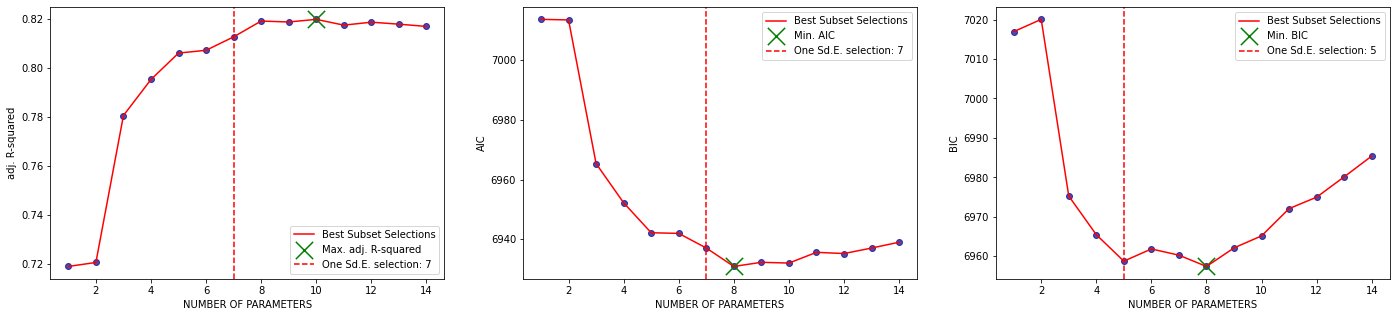

In [ ]:
df1,df2,df3=S.ic(df_bs_min_rss['variables'],df_train_auswahl,df_test,output='salary')
fig=plt.figure(figsize=(24,5))
ax=fig.add_subplot(1,3,1)
ax.scatter(df1.nf,df1.r_squaredadj,alpha=0.7,color='darkblue')
ax.set_xlabel('NUMBER OF PARAMETERS')
ax.set_ylabel('adj. R-squared')
ax.plot(df1.nf,df1.r_squaredadj,color='r',label='Best Subset Selections')
ax.scatter(df2.iloc[2].nf,df2.iloc[2].r_squaredadj,s=300,c='g',marker='x',label='Max. adj. R-squared ')
ax.axvline(df3['One SE adj R sq'],c='r',linestyle='--',label='One Sd.E. selection: {f}'.format(f=df3['One SE adj R sq']))
ax.legend()

ax=fig.add_subplot(1,3,2)
ax.scatter(df1.nf,df1.aic,alpha=0.7,color='darkblue')
ax.set_xlabel('NUMBER OF PARAMETERS')
ax.set_ylabel('AIC')
ax.plot(df1.nf,df1.aic,color='r',label='Best Subset Selections')
ax.scatter(df2.iloc[0].nf,df2.iloc[0].aic,s=300,c='g',marker='x',label='Min. AIC')
ax.axvline(df3['One SE AIC'],c='r',linestyle='--',label='One Sd.E. selection: {f}'.format(f=df3['One SE AIC']))
ax.legend()

ax=fig.add_subplot(1,3,3)
ax.scatter(df1.nf,df1.bic,alpha=0.7,color='darkblue')
ax.set_xlabel('NUMBER OF PARAMETERS')
ax.set_ylabel('BIC')
ax.plot(df1.nf,df1.bic,color='r',label='Best Subset Selections')
ax.scatter(df2.iloc[1].nf,df2.iloc[1].bic,s=300,c='g',marker='x',label='Min. BIC')
ax.axvline(df3['One SE BIC'],c='r',linestyle='--',label='One Sd.E. selection: {f}'.format(f=df3['One SE BIC']))
ax.legend()
#plt.savefig('abschnitt.png')
plt.show()

* **We implement a method to frequently plot our results by reusing code**

* **The following plot shows the subset selections for the three information criterion and the directly estimated test mean squared error for all three subset selection methods(Figure 4.5.2)**

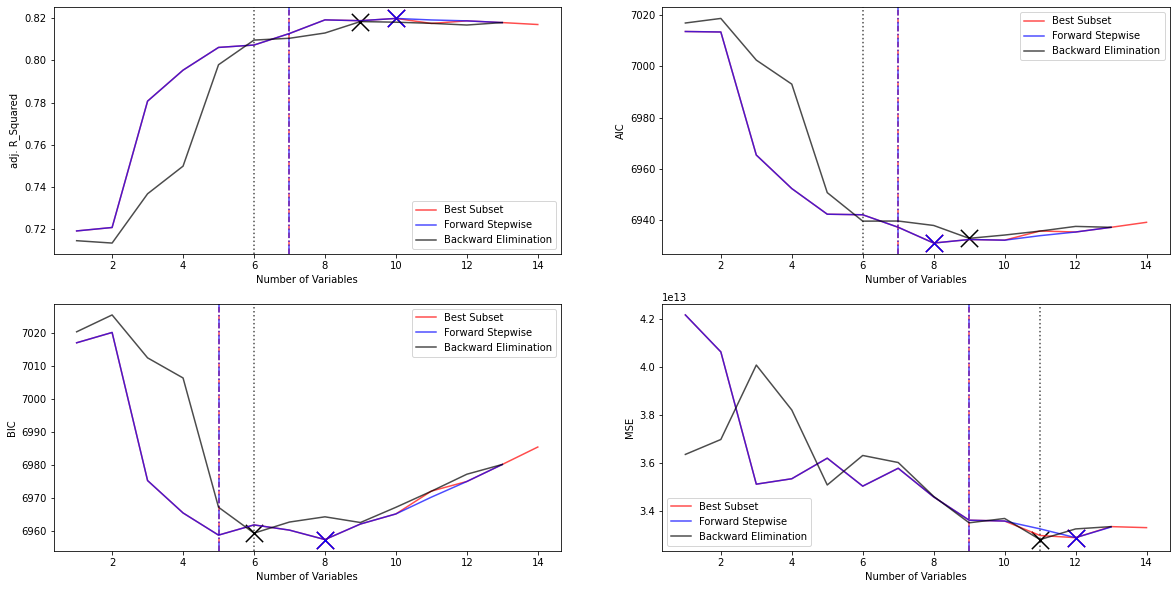

In [ ]:
df1_be,df2_be,df3_be=S.ic(df_be['Variables'],df_train,df_test,output='salary')
df1_fss,df2_fss,df3_fss=S.ic(df_fss['variables'],df_train,df_test,output='salary')
df1_bs,df2_bs,df3_bs=S.ic(df_bs_min_rss['variables'],df_train,df_test,output='salary')

S.ic_plot(df1_bs,df2_bs,df3_bs,df1_fss,df2_fss,df3_fss,df1_be,df2_be,df3_be,
          one='Best Subset',two='Forward Stepwise',three='Backward Elimination',pngname='Figure 4.5.2')

## Comparison with created data
1. Implementation of the data generating method
2. Creating the data
3. Using the data

In [ ]:
#creating data set 1 with 15 observations
X1,y1=G.dataset_declaration(15,related=0,mu=0,sigma=1,noise=12)
df_self1=pd.DataFrame(X1)
df_self1['pred']=y1
df_train1= df_self1.sample(frac=0.75,random_state=1)
df_test1=df_self1.drop(df_train1.index)

#creating data set 2 with 150 observations
X2,y2=G.dataset_declaration(150,related=0,mu=0,sigma=1,noise=12)
df_self2=pd.DataFrame(X2)
df_self2['pred']=y2
df_train2= df_self2.sample(frac=0.75,random_state=1)
df_test2=df_self2.drop(df_train2.index)

AttributeError: type object 'General' has no attribute 'dataset_declaration'

In [ ]:
#computing the best subset selections
df_bs_1=S.best_subset(df_train1,output='pred')
df_bs_1_rss=df_bs_1[df_bs_1['min_RSS']==df_bs_1['RSS']][['number_of_variables','RSS','R_squared','variables']].reset_index()
df_bs_1_rss=df_bs_1_rss.drop(['index'], axis=1)
df_bs_2=S.best_subset(df_train2,output='pred')
df_bs_2_rss=df_bs_2[df_bs_2['min_RSS']==df_bs_2['RSS']][['number_of_variables','RSS','R_squared','variables']].reset_index()
df_bs_2_rss=df_bs_2_rss.drop(['index'], axis=1)

In [ ]:
#displaying our results -> Figure 4.5.3
from IPython.display import display_html
df1=df_bs_1_rss
df2=df_bs_2_rss
df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('15 observations and 12 unrelated predictors')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('150 observations and 12 unrelated predictors')
space = "\xa0" 
display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_(), raw=True)

,number_of_variables,RSS,R_squared,variables
0,1,3.547795,0.370055,[8]
1,2,1.511968,0.731536,"[8, 9]"
2,3,0.763195,0.864487,"[8, 9, 11]"
3,4,0.377244,0.933017,"[7, 8, 9, 11]"
4,5,0.212006,0.962356,"[1, 7, 8, 9, 11]"
5,6,0.108424,0.980748,"[0, 4, 5, 6, 7, 10]"
6,7,0.029149,0.994824,"[0, 2, 3, 8, 9, 10, 11]"
7,8,0.002092,0.999629,"[0, 3, 4, 5, 6, 7, 10, 11]"
8,9,0.000029,0.999995,"[0, 3, 4, 5, 6, 7, 9, 10, 11]"
9,10,0.000000,1.000000,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 11]"


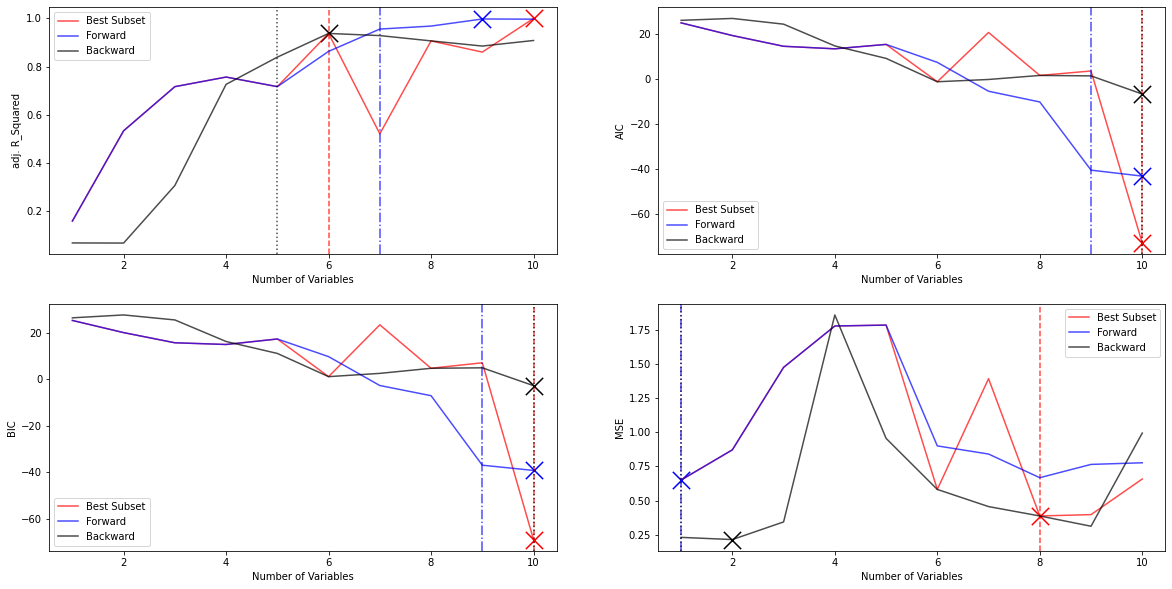

In [ ]:
df_be=S.backwards_elimination(df_train1,output='pred')
df1_be,df2_be,df3_be=S.ic(df_be['Variables'],df_train1,df_test1,output='pred')
df_fss=S.forward_stepwise(df_train1,output='pred')
df1_fss,df2_fss,df3_fss=S.ic(df_fss['variables'],df_train1,df_test1,output='pred')
df1_bs,df2_bs,df3_bs=S.ic(df_bs_1_rss['variables'],df_train1,df_test1,output='pred')
#plotting Figure 4.5.4
S.ic_plot(df1_bs,df2_bs,df3_bs,df1_fss,df2_fss,df3_fss,df1_be,df2_be,df3_be,
          one='Best Subset',two='Forward',three='Backward',pngname='own data 15 observations')

## Shrinkage processes
* Ridge regression
* Lasso regression

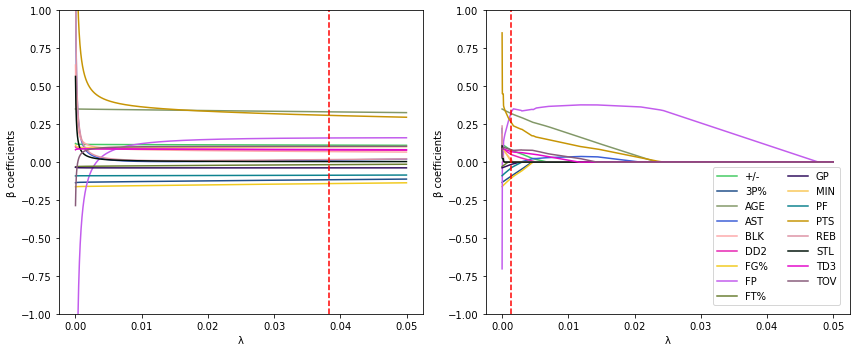

In [ ]:
a=np.arange(0.0,0.05,0.00001)#these are all lambda values we will be setting as alpha into lasso or ridge
df=(df-df.mean())/df.std()#standardizing the data set

df_train= df.sample(frac=0.75,random_state=1)
df_test=df.drop(df_train.index)
min_mse,y_pos,mse_list,r_squared_list,df_p=R.best_lambda(a,df_train,df_test,output='salary',methode='ridge')

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout(pad=0.01, w_pad=3, h_pad=1.0)

random.seed(1)
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
color=get_colors(df_p.shape[1])

ax[0].set_prop_cycle(color=color)
for i in df_p.columns:
    ax[0].plot(a,df_p[i],label=i)
ax[0].axvline(x=y_pos, color='r',linestyle='--',label= "λ: {f}".format(f=y_pos))
ax[0].set_ylim(-1,1)
ax[0].set_ylabel("β coefficients")
ax[0].set_xlabel("λ")
ax[1].set_prop_cycle(color=color)

min_mse,y_pos,mse_list,r_squared_list,df_p=R.best_lambda(a,df_train,df_test,output='salary',methode='lasso')
for i in df_p.columns:
    ax[1].plot(a,df_p[i],label=i)
ax[1].set_ylim(-1,1)
ax[1].axvline(x=y_pos, color='r',linestyle='--')
ax[1].legend(bbox_to_anchor=(0.8,0.5), loc="upper center",ncol=2)
ax[1].set_ylabel("β coefficients")
ax[1].set_xlabel("λ")
plt.tight_layout()
plt.savefig('Figure 4 6 2.png')
plt.show()   

# Creating multiple splits

* **First for the standardized NBA data Set**

In [ ]:
df=(df-df.mean())/df.std()
df = pd.read_csv("NBA_salaries_and_stats.csv", sep=",")
df=df[['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']]#new data
df=(df-df.mean())/df.std()

count=15
a_r=np.arange(0,1.,0.01)
a_l=np.arange(0,0.02,0.0001)
ridge,lasso,y_train,X_train,y_test,X_test=R.mult_split(df,a_r,a_l,count=count)

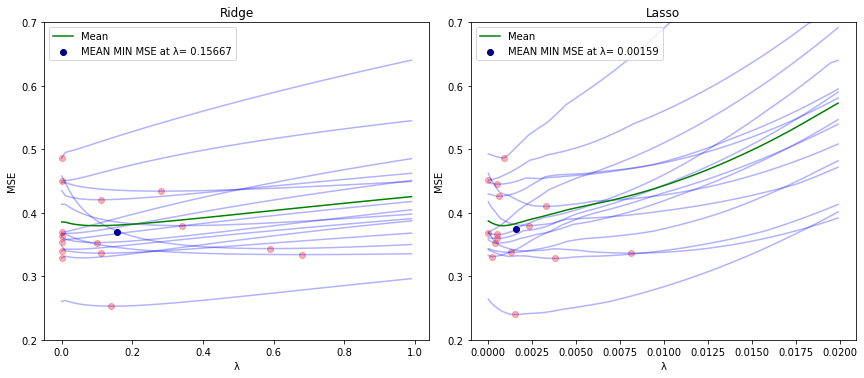

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
from operator import add
fig.tight_layout()

ridgel=[b[2]for b in ridge]
ridge_mse_mean=np.sum([b[2]for b in ridge],0)/count


ridge_y_pos_mean=np.sum([b[1] for b in ridge])/count
ridge_min_mse_mean=np.sum([b[0] for b in ridge])/count

for b in ridge:
    min_mse,y_pos,mse_list,r_squared_list,df_p=b   
    ax[0].plot(a_r,mse_list,color='b',alpha=0.3)
    ax[0].scatter(y_pos,min_mse,color='r',alpha=0.3)

ax[0].plot(a_r,ridge_mse_mean,color='g',label='Mean',alpha=1.0)
ax[0].scatter(ridge_y_pos_mean,ridge_min_mse_mean,color='Navy',label='MEAN MIN MSE at λ= '+str(round(ridge_y_pos_mean,5)),alpha=1.0)
ax[0].set_ylim(0.2,0.7)   
ax[0].set_xlabel('λ')
ax[0].set_ylabel('MSE')
ax[0].legend()
ax[0].set_title('Ridge')
 
lasso_mse_mean=np.sum([b[2]for b in lasso],0)/count
lasso_y_pos_mean=np.sum([b[1] for b in lasso])/count
lasso_min_mse_mean=np.sum([b[0] for b in lasso])/count

for b in lasso:
    min_mse,y_pos,mse_list,r_squared_list,df_p=b   
    ax[1].plot(a_l,mse_list,color='b',alpha=0.3)
    ax[1].scatter(y_pos,min_mse,color='r',alpha=0.3)

ax[1].plot(a_l,lasso_mse_mean,color='g',label='Mean',alpha=1.0)
ax[1].scatter(lasso_y_pos_mean,lasso_min_mse_mean,color='Navy',label='MEAN MIN MSE at λ= '+str(round(lasso_y_pos_mean,5)),alpha=1.0)
ax[1].set_ylim(0.2,0.7)  
ax[1].set_xlabel('λ')
ax[1].set_ylabel('MSE')
ax[1].legend(loc='upper left')
ax[1].set_title('Lasso')
#plt.savefig('ridge_lasso_multisplit.png')    
plt.show()

* **Then for a created data set -> Figure 4.6.3**

In [ ]:
X,y=G.dataset_declaration(15,related=5,mu=0,sigma=1,noise=12)
df_self=pd.DataFrame(X)
df_self['pred']=y
df_train= df_self.sample(frac=0.75,random_state=1)
df_test=df_self.drop(df_train.index)

In [ ]:
count=15
a_r=np.arange(0,2,0.01)
a_l=np.arange(0,0.001,0.00001)
ridge,lasso,y_train,X_train,y_test,X_test=R.mult_split(df_self,a_r,a_l,count=count,output='pred')

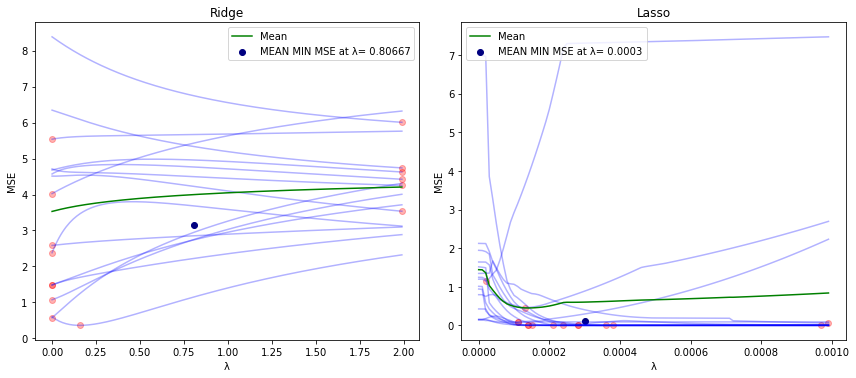

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
from operator import add
fig.tight_layout()

ridgel=[b[2]for b in ridge]
ridge_mse_mean=np.sum([b[2]for b in ridge],0)/count


ridge_y_pos_mean=np.sum([b[1] for b in ridge])/count
ridge_min_mse_mean=np.sum([b[0] for b in ridge])/count

for b in ridge:
    min_mse,y_pos,mse_list,r_squared_list,df_p=b   
    ax[0].plot(a_r,mse_list,color='b',alpha=0.3)
    ax[0].scatter(y_pos,min_mse,color='r',alpha=0.3)

ax[0].plot(a_r,ridge_mse_mean,color='g',label='Mean',alpha=1.0)
ax[0].scatter(ridge_y_pos_mean,ridge_min_mse_mean,color='Navy',label='MEAN MIN MSE at λ= '+str(round(ridge_y_pos_mean,5)),alpha=1.0)
#ax[0].set_ylim(0.2,0.7)   
ax[0].set_xlabel('λ')
ax[0].set_ylabel('MSE')
ax[0].legend()
ax[0].set_title('Ridge')
 
lasso_mse_mean=np.sum([b[2]for b in lasso],0)/count
lasso_y_pos_mean=np.sum([b[1] for b in lasso])/count
lasso_min_mse_mean=np.sum([b[0] for b in lasso])/count

for b in lasso:
    min_mse,y_pos,mse_list,r_squared_list,df_p=b   
    ax[1].plot(a_l,mse_list,color='b',alpha=0.3)
    ax[1].scatter(y_pos,min_mse,color='r',alpha=0.3)

ax[1].plot(a_l,lasso_mse_mean,color='g',label='Mean',alpha=1.0)
ax[1].scatter(lasso_y_pos_mean,lasso_min_mse_mean,color='Navy',label='MEAN MIN MSE at λ= '+str(round(lasso_y_pos_mean,5)),alpha=1.0)
#ax[1].set_ylim(0.2,0.7)  
ax[1].set_xlabel('λ')
ax[1].set_ylabel('MSE')
ax[1].legend(loc='upper left')
ax[1].set_title('Lasso')
#plt.savefig('Figure 4 6 3.png')    
plt.show()

# Comparing the results of each method 
* **selection: its main purpose is to determines the variable selection property of the lasso regression**
* **min_mse: calculates the test mean squarred error estimate for a given subset dataframe**
* **mult_split_be: computes the backwards elimination and forward stepwise selection for multiple splits**
* **choice: counts the number of included variables in the given subset dataframe**
* **meanf: determines the minimal test mse mean and the mean number of non-zero variables over different splits**

* **exemplary output of the selection method**

In [ ]:
df = pd.read_csv("NBA_salries_and_stats.csv", sep=",")
df=df[['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']]#new data
df=(df-df.mean())/df.std()

count=15
a_r=np.arange(0,2.,0.01)
a_l=np.arange(0,0.02,0.0001)
ridge,lasso,y_train,X_train,y_test,X_test=R.mult_split(df,a_r,a_l,count=count)

In [ ]:
k,d=R.selection(lasso,y_train,X_train,count=count,threshold=0.9,method='Lasso')
display(k)
k,d=R.selection(ridge,y_train,X_train,count=count,threshold=0.9,method='Ridge')
display(d)

,+/-,3P%,TD3,REB,PTS,PF,MIN,GP,FT%,FG%,BLK,AGE,TOV,DD2,STL,AST,FP
Count Lasso,15,15,15,15,15,15,15,15,15,15,15,15,15,14,14,10,9


,Count,+/-,3P%,AGE,AST,BLK,DD2,FG%,FP,FT%,GP,MIN,PF,PTS,REB,STL,TD3,TOV
0,17,0.111735,-0.129521,0.363136,0.242529,0.183107,0.082580,-0.176255,-0.715386,-0.024123,-0.035202,0.086365,-0.068421,0.887085,0.268452,0.119114,0.117256,-0.027987
1,17,0.081546,-0.141124,0.386106,-0.028300,0.078535,-0.104453,-0.202448,0.287158,-0.006552,-0.039926,-0.084231,-0.030625,0.579751,0.093341,-0.044662,0.079489,0.019102
2,17,0.070791,-0.045016,0.304042,0.569770,0.384314,0.068870,-0.187536,-2.013206,-0.031574,-0.012675,-0.028168,-0.127082,1.677588,0.663770,0.294209,0.116950,-0.055301
3,17,0.088131,-0.097095,0.333454,0.365315,0.229429,-0.048474,-0.149423,-0.981328,-0.009759,-0.052424,-0.011262,-0.084500,1.072366,0.470870,0.119405,0.104088,-0.017956
4,17,0.122990,-0.089090,0.306231,0.584766,0.382815,0.009753,-0.180334,-1.816177,-0.016230,-0.010513,-0.040333,-0.133995,1.566680,0.690075,0.266231,0.093264,-0.123211
5,17,0.037798,-0.106480,0.360174,0.679535,0.421448,0.034656,-0.159532,-2.372540,-0.000470,-0.000603,0.014749,-0.084929,1.861252,0.781559,0.334596,-0.030958,-0.141133
6,17,0.053481,-0.110810,0.345391,0.263815,0.263442,0.064058,-0.178299,-0.569250,-0.013654,-0.008478,-0.009585,-0.112815,0.894023,0.212955,0.096257,0.062033,-0.037656
7,17,0.064864,-0.085869,0.333803,0.091658,0.134648,-0.056126,-0.154134,0.174365,0.017906,-0.069183,-0.096712,-0.116062,0.426548,0.184051,0.020384,0.050939,0.181053
8,17,0.056499,-0.088043,0.364391,-0.033309,0.129503,-0.071910,-0.166120,0.046345,-0.004473,-0.022114,0.043170,-0.163509,0.446908,0.227368,0.014110,0.157623,0.125689
9,17,0.037585,-0.078732,0.290078,0.214063,0.133551,0.055026,-0.078179,-0.005731,0.007079,-0.056462,-0.071197,-0.137710,0.591579,0.074274,0.031503,-0.007996,0.065574


# Combining the methods on the standardized NBA data set

In [ ]:
df = pd.read_csv("NBA_salaries_and_stats.csv", sep=",")
df=df[['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']]
df=(df-df.mean())/df.std()
op='salary'

count=15
a_r=np.arange(0,2.,0.01)
a_l=np.arange(0,2.,0.01)
#calculating the methods over multiple splits
ridge,lasso,y_train,X_train,y_test,X_test=R.mult_split(df,a_r,a_l,count=count)
backwards,forwards,df_train,df_test,be_mse,fss_mse=R.mult_split_be(df,count=count,frac=0.7,output=op)

In [ ]:
cols=['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']
df_be=C.choice(be_mse,cols,'backwards',count=count,output=op)
df_fss=C.choice(fss_mse,cols,'forwards',count=count,output=op)


df_lasso=R.selection(lasso,y_train,X_train,count=count,threshold=0.9,method='Lasso')[0]

df_ridge=R.selection(ridge,y_train,X_train,count=count,threshold=0.9,method='Ridge')[0]

df_sub=pd.concat([df_be,df_fss,df_ridge,df_lasso],join="inner")
df_sub=df_sub.sort_values(by='Count backwards',axis=1,ascending=False)
display(df_sub)
#display the variables that are included in 50% of the model
display(df_sub[df_sub>0.5*count].dropna(axis=1))

df_mean=C.meanf(be_mse,fss_mse,lasso,ridge,df_lasso,df_ridge)
df_sub.index=df_mean.index
display(df_mean)
df_sub['mean min MSE']=df_mean['min_mse_mean']
df_sub['mean number variables']=df_mean['nf_mean']

,PTS,AGE,BLK,FG%,3P%,REB,+/-,AST,TD3,PF,FP,STL,TOV,GP,DD2,MIN,FT%
Count backwards,15,15,10,10,10,10,9,9,9,9,6,6,3,2,2,1,1
Count forwards,9,15,8,11,9,5,8,4,8,10,14,4,6,4,1,4,1
Count Ridge,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
Count Lasso,15,15,15,15,15,14,15,11,15,15,15,13,14,15,12,14,13


,PTS,AGE,BLK,FG%,3P%,+/-,TD3,PF
Count backwards,15,15,10,10,10,9,9,9
Count forwards,9,15,8,11,9,8,8,10
Count Ridge,15,15,15,15,15,15,15,15
Count Lasso,15,15,15,15,15,15,15,15


,min_mse_mean,nf_mean
Backwards,0.369060,8.466670
Forwards,0.372180,8.066670
Ridge,0.369841,15.000000
Lasso,0.381770,14.176471


* **Figure 4.7.1**

In [ ]:
display(df_sub)

,PTS,AGE,BLK,FG%,3P%,REB,+/-,AST,TD3,PF,FP,STL,TOV,GP,DD2,MIN,FT%,mean min MSE,mean number variables
Backwards,15,15,10,10,10,10,9,9,9,9,6,6,3,2,2,1,1,0.369060,8.466670
Forwards,9,15,8,11,9,5,8,4,8,10,14,4,6,4,1,4,1,0.372180,8.066670
Ridge,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.369841,15.000000
Lasso,15,15,15,15,15,14,15,11,15,15,15,13,14,15,12,14,13,0.381770,14.176471
